<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220531.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* GridSearchCV

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timezone, timedelta
import plotnine as gg
from plotnine import ggplot, aes
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, mean_squared_error
import sklearn.datasets as skd

# GridSearchCV

In [4]:
raw = skd.make_classification(n_samples = 30000, n_features = 13)
X = pd.DataFrame(raw[0])
y = raw[1]

In [7]:
X.columns = [f'col{a:02d}' for a in range(13)]
X.head()

,col00,col01,col02,col03,col04,col05,col06,col07,col08,col09,col10,col11,col12
0,0.470807,0.527733,-0.041878,-0.877046,-0.302801,1.323517,-1.106235,-0.592559,0.768227,-1.410027,-0.023521,-0.679011,0.767516
1,1.203714,-0.276715,-0.486939,1.013661,0.631248,-1.691887,1.321862,0.009870,-1.322252,-0.766005,0.020574,0.609808,-1.082096
2,-0.445979,1.447737,-0.994733,0.854250,-0.306555,-0.926293,-0.130713,-0.598571,-0.970407,-1.598574,-0.036939,-1.013216,-1.126808
3,0.441917,-0.246351,-0.957445,0.369113,-1.053217,0.740522,-0.973013,0.787712,0.836374,-0.365531,0.000269,-0.012857,0.540110
4,-1.616670,2.572545,-0.521702,0.538282,-1.234232,1.901175,1.834605,-0.694651,1.061997,-0.254525,-0.090611,-2.569482,0.136380


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


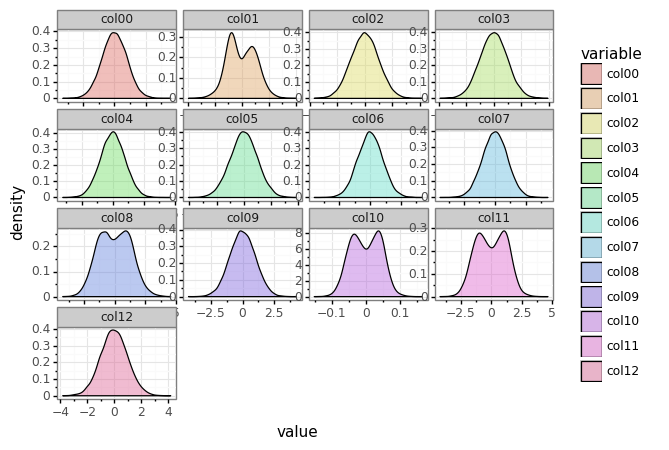

<ggplot: (8745217360717)>

In [11]:
(
    ggplot(pd.melt(X.assign(id = 1), id_vars = 'id'), aes('value', fill = 'variable')) +
    gg.geom_density(alpha = .4) +
    gg.facet_wrap('~variable', scales = 'free') +
    gg.theme_bw()
)

In [12]:
x_tr, x_te, y_tr, y_te = train_test_split(X,y, train_size = .7)

In [14]:
fit_rf = RandomForestClassifier().fit(x_tr, y_tr)
fit_gb = GradientBoostingClassifier().fit(x_tr, y_tr)

In [16]:
pred_rf = fit_rf.predict(x_te)
pred_gb = fit_gb.predict(x_te)
proba_rf = fit_rf.predict_proba(x_te)[:,-1]
proba_gb = fit_gb.predict_proba(x_te)[:,-1]

In [18]:
accuracy_score(y_te, pred_rf), accuracy_score(y_te, pred_gb)

(0.8968888888888888, 0.8998888888888888)

In [23]:
roc_auc_score(y_te, pred_rf), roc_auc_score(y_te, pred_gb)

(0.8970520920992832, 0.9000374606592693)

In [20]:
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_te, proba_rf)
fpr_gb, tpr_gb, threshold_gb = roc_curve(y_te, proba_gb)

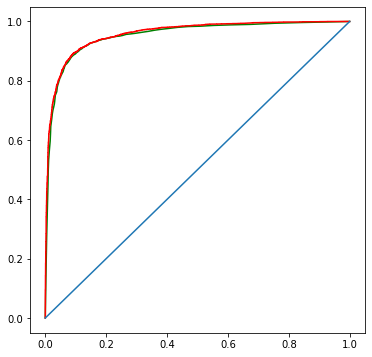

In [29]:
plt.figure(figsize = [6, 6])
plt.plot(fpr_rf, tpr_rf, color = 'green')
plt.plot(fpr_gb, tpr_gb, color = 'red')
plt.plot([0,1],[0,1])

In [31]:
fit_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [32]:
params = {'n_estimators' : [100, 200],
          'min_samples_leaf' : [1, 2, 4, 8 ,12],
          'min_samples_split' : [2, 4, 8, 12]
          }

In [35]:
grid_rf = GridSearchCV(fit_rf, param_grid = params, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid_rf.fit(x_tr, y_tr)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 4, 8, 12],
                         'min_samples_split': [2, 4, 8, 12],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [36]:
grid_rf.best_params_

{'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}

In [37]:
fit_rf_best = RandomForestClassifier(min_samples_leaf = 8,
                                     min_samples_split = 8,
                                     n_estimators = 100
                                     ).fit(x_tr, y_tr)

In [38]:
pred_rf_best = fit_rf_best.predict(x_te)
proba_rf_best = fit_rf_best.predict_proba(x_te)[:,-1]

In [39]:
roc_auc_score(y_te, pred_rf),roc_auc_score(y_te, pred_rf_best)

(0.8970520920992832, 0.8987344876491702)

In [41]:
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_te, proba_rf)
fpr_best, tpr_best, threshold_best = roc_curve(y_te, proba_rf_best)

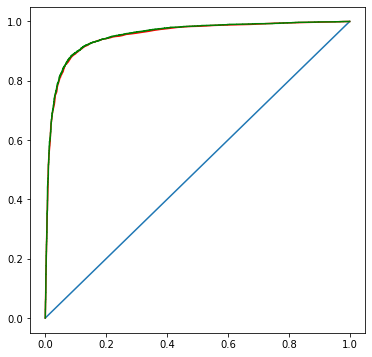

In [43]:
plt.figure(figsize = [6, 6])
plt.plot([0,1], [0,1])
plt.plot(fpr_rf, tpr_rf, color = 'red')
plt.plot(fpr_best, tpr_best, color = 'green')